In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy/Energy_consumption_India_2.csv')
df.head()

,States,Regions,latitude,longitude,Dates,Usage
0,Punjab,NR,31.519974,75.980003,02/01/2019 00:00:00,119.9
1,Haryana,NR,28.450006,77.019991,02/01/2019 00:00:00,130.3
2,Rajasthan,NR,26.449999,74.639981,02/01/2019 00:00:00,234.1
3,Delhi,NR,28.669993,77.230004,02/01/2019 00:00:00,85.8
4,UP,NR,27.599981,78.050006,02/01/2019 00:00:00,313.9


In [4]:
df.tail()

,States,Regions,latitude,longitude,Dates,Usage
16594,Manipur,NER,24.799971,93.950017,05/12/2020 00:00:00,2.5
16595,Meghalaya,NER,25.570492,91.880014,05/12/2020 00:00:00,5.8
16596,Mizoram,NER,23.710399,92.720015,05/12/2020 00:00:00,1.6
16597,Nagaland,NER,25.666998,94.116570,05/12/2020 00:00:00,2.1
16598,Tripura,NER,23.835404,91.279999,05/12/2020 00:00:00,3.3


In [5]:
df.shape

(16599, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16599 entries, 0 to 16598
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   States     16599 non-null  object 
 1   Regions    16599 non-null  object 
 2   latitude   16599 non-null  float64
 3   longitude  16599 non-null  float64
 4   Dates      16599 non-null  object 
 5   Usage      16599 non-null  float64
dtypes: float64(3), object(3)
memory usage: 778.2+ KB


In [7]:
df.isnull().sum()

States       0
Regions      0
latitude     0
longitude    0
Dates        0
Usage        0
dtype: int64

In [8]:
df['date'] = pd.to_datetime(df['Dates'])

In [9]:
plt.rcParams['figure.figsize'] = [15,8]

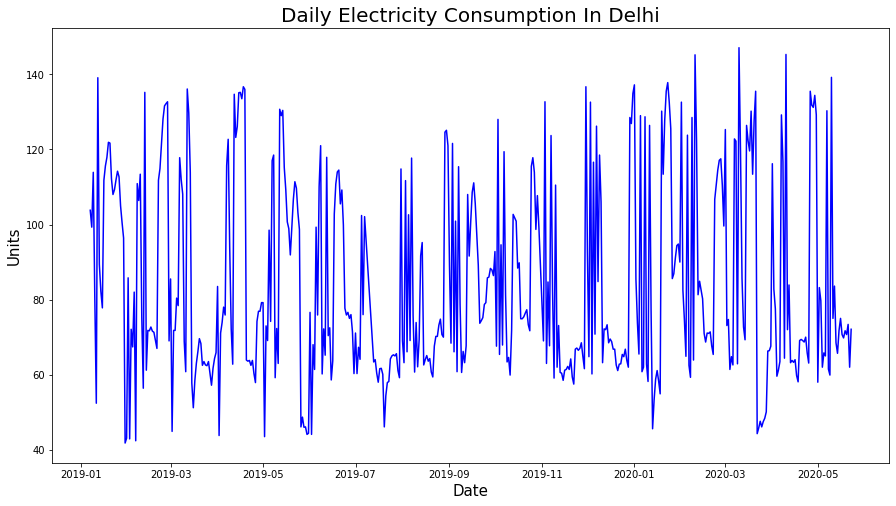

In [10]:
df_del = df[df['States'] == 'Delhi']
df_del_grp = df_del.groupby('date').agg({'Usage':'sum'})
plt.plot(df_del_grp,color='blue',linewidth=1.5)
plt.title('Daily Electricity Consumption In Delhi',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [11]:
len(df_del_grp)

498

In [12]:
time = pd.date_range(start='1/7/2019',periods=498,freq='D')

In [13]:
df_del_grp.set_index(time,inplace=True)

In [14]:
df_del_grp

,Usage
2019-01-07,103.8
2019-01-08,99.3
2019-01-09,113.9
2019-01-10,80.7
2019-01-11,52.4
...,...
2020-05-14,71.7
2020-05-15,70.7
2020-05-16,73.4
2020-05-17,62.0


In [15]:
df = df_del_grp.copy()

In [16]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,])
        Y.append(data_arr[d,])
    return np.array(X), np.array(Y)

In [17]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['Usage'] = df['Usage'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1)) #LTSM requires more input features compared to RNN or DNN
scaler = MinMaxScaler(feature_range=(0.1, 1))#LTSM is senstive to the scale of features
df_arr = scaler.fit_transform(df_arr)

In [18]:
train_size = 450
train, test = df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
look_back = 6
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [19]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(444, 1, 6)
(444, 1)
(42, 1, 6)
(42, 1)


In [20]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.5 MB/s 


In [21]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [22]:
def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(hp.Int('first_lstm_layer',min_value=8,max_value=128,step=8), activation="relu",return_sequences=True, input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.2,0.4,0.6],default=0.4)))
    model.add(LSTM(hp.Int('final_lstm_layer',min_value=8,max_value=128,step=8),activation="relu",recurrent_dropout = hp.Choice("last_recurrent_dropout",[0.2,0.4,0.6],default=0.4) ))
    model.add(Dense(hp.Int('dense_layer_1',min_value=8,max_value=128,step=8),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [23]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=20,
    executions_per_trial=2,
    directory='project',
    project_name='del_consum')

In [24]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
first_lstm_layer (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
final_lstm_layer (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
last_recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
dense_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [25]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=32,
             validation_data=(testX, testY))

Trial 20 Complete [00h 01m 21s]
val_mape: 22.276803016662598

Best val_mape So Far: 20.087186813354492
Total elapsed time: 00h 27m 41s
INFO:tensorflow:Oracle triggered exit


In [26]:
tuner.results_summary()

Results summary
Results in project/del_consum
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
first_lstm_layer: 80
first_recurrent_dropout: 0.4
final_lstm_layer: 112
last_recurrent_dropout: 0.2
dense_layer_1: 96
Dropout_rate: 0.30000000000000004
learning_rate: 0.013690364144632332
Score: 20.087186813354492
Trial summary
Hyperparameters:
first_lstm_layer: 72
first_recurrent_dropout: 0.2
final_lstm_layer: 24
last_recurrent_dropout: 0.4
dense_layer_1: 96
Dropout_rate: 0.1
learning_rate: 0.009824711447422326
Score: 21.201095581054688
Trial summary
Hyperparameters:
first_lstm_layer: 72
first_recurrent_dropout: 0.2
final_lstm_layer: 16
last_recurrent_dropout: 0.2
dense_layer_1: 112
Dropout_rate: 0.4
learning_rate: 0.014580983761541077
Score: 21.465468406677246
Trial summary
Hyperparameters:
first_lstm_layer: 80
first_recurrent_dropout: 0.6
final_lstm_layer: 88
last_recurrent_dropout: 0.6
dense_layer_1: 120
Dropout_rate: 0.5
learning_rate: 0.0

In [27]:
from warnings import filterwarnings
filterwarnings('ignore')

In [28]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 6))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 80)             27840     
                                                                 
 lstm_1 (LSTM)               (None, 112)               86464     
                                                                 
 dense (Dense)               (None, 96)                10848     
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 97        
                                                                 
Total params: 125,249
Trainable params: 125,249
Non-trainable params: 0
_________________________________________________________________


In [30]:
from tensorflow.keras import optimizers

In [50]:
model = Sequential()
model.add(LSTM(30,activation='relu',return_sequences=True,input_shape=(1,look_back), recurrent_dropout=0.3))
model.add(LSTM(20,activation='relu',recurrent_dropout=0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.00053690364144632332)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX, testY), batch_size = 32, epochs = 200)

Epoch 1/200
14/14 [==============================] - 5s 52ms/step - loss: 99.9724 - mape: 99.9724 - val_loss: 99.9453 - val_mape: 99.9453
Epoch 2/200
14/14 [==============================] - 0s 8ms/step - loss: 99.9219 - mape: 99.9219 - val_loss: 99.8868 - val_mape: 99.8868
Epoch 3/200
14/14 [==============================] - 0s 9ms/step - loss: 99.8595 - mape: 99.8595 - val_loss: 99.8128 - val_mape: 99.8128
Epoch 4/200
14/14 [==============================] - 0s 8ms/step - loss: 99.7766 - mape: 99.7766 - val_loss: 99.7131 - val_mape: 99.7131
Epoch 5/200
14/14 [==============================] - 0s 8ms/step - loss: 99.6652 - mape: 99.6652 - val_loss: 99.5714 - val_mape: 99.5714
Epoch 6/200
14/14 [==============================] - 0s 11ms/step - loss: 99.4921 - mape: 99.4921 - val_loss: 99.3563 - val_mape: 99.3563
Epoch 7/200
14/14 [==============================] - 0s 8ms/step - loss: 99.2257 - mape: 99.2257 - val_loss: 99.0159 - val_mape: 99.0159
Epoch 8/200
14/14 [====================

In [51]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

Train MAPE : 18.65 
Test MAPE : 14.60 


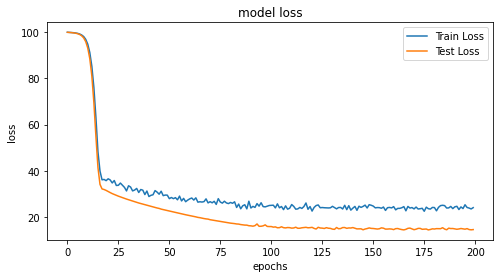

In [52]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform(trainY)
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform(testY)
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [53]:
import seaborn as sns

In [54]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(444,486)]
    plt.plot(trainY)
    plt.plot(len_prediction, testY, marker='.', label="actual")
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Consumption', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

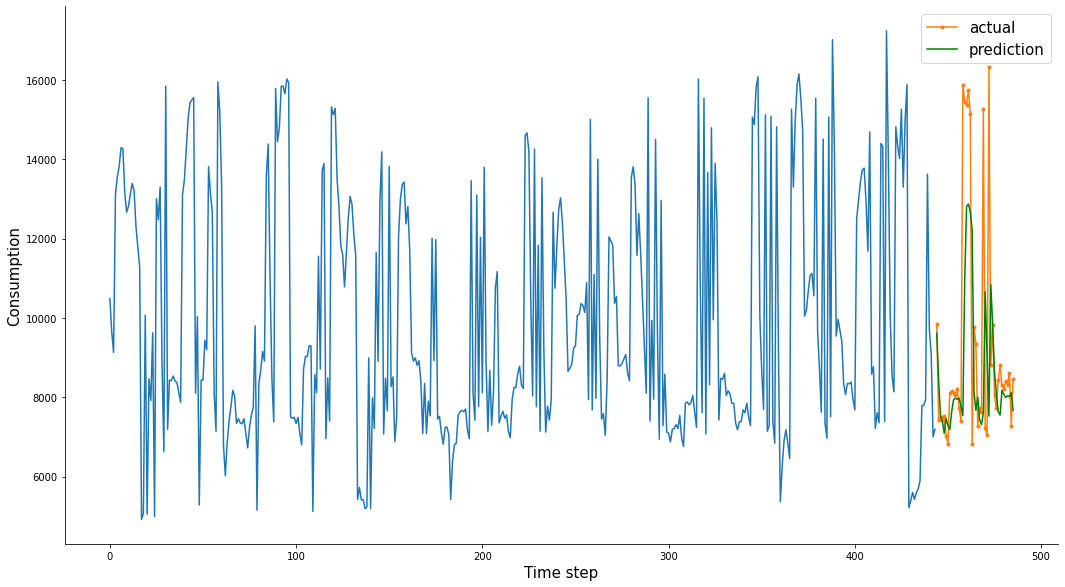

In [55]:
test_predict_scaled = model.predict(testX)
test_predict_inv = scaler.inverse_transform(test_predict_scaled)
prediction_plot(testY, test_predict_inv,look_back)